In [79]:
%matplotlib inline
import pyNN.nest as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer
import matplotlib.pyplot as plt
import pylab
import numpy as np

timer = Timer()
p.setup(timestep=0.1) # 0.1ms 

rngseed = 98766987
parallel_safe = True
rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

In [80]:
n = 150          # number of cells
exc_ratio = 0.8   # ratio of excitatory neurons

n_exc = int(round(n*0.8))
n_inh = n-n_exc
print n_exc, n_inh


celltype = p.Izhikevich()
# default_parameters = {'a': 0.02, 'c': -65.0, 'd': 2.0, 'b': 0.2, 'i_offset': 0.0}¶
#  default_initial_values = {'v': -70.0, 'u': -14.0}¶
exc_cells = p.Population(n_exc, celltype, label="Excitatory_Cells")
inh_cells = p.Population(n_inh, celltype, label="Inhibitory_Cells")

poisson_input = p.SpikeSourcePoisson(rate = 10, start = 2.)
input_neurons = p.Population(10, poisson_input, label='input')

120 30


In [81]:
exc_cells.celltype.recordable

['spikes', 'v', 'u']

In [82]:
pconn = 0.1      # sparse connection probability
w_exc = 7.6   # later add unit
w_inh = -28.   # later add unit
delay_exc = 1.      # defines how long (ms) the synapse takes for transmission
delay_inh = 1.

stat_syn_exc = p.StaticSynapse(weight =w_exc, delay=delay_exc)
stat_syn_inh = p.StaticSynapse(weight =w_inh, delay=delay_inh)

exc_conn = p.FixedProbabilityConnector(pconn, rng=rng)
inh_conn = p.FixedProbabilityConnector(pconn, rng=rng)
inp_conn = p.FixedProbabilityConnector(0.2, rng=rng)

connections = {}
connections['e2e'] = p.Projection(exc_cells, exc_cells, exc_conn,
                                synapse_type=stat_syn_exc, receptor_type='excitatory')
connections['e2i'] = p.Projection(exc_cells, inh_cells, exc_conn,
                                synapse_type=stat_syn_exc,receptor_type='excitatory')
connections['i2e'] = p.Projection(inh_cells, exc_cells, inh_conn,
                                synapse_type=stat_syn_inh,receptor_type='inhibitory')
connections['i2i'] = p.Projection(inh_cells, inh_cells, inh_conn,
                                synapse_type=stat_syn_inh,receptor_type='inhibitory')

connections['inp2e'] = p.Projection(input_neurons, exc_cells, inp_conn,
                                      synapse_type=stat_syn_exc,receptor_type='excitatory')
connections['inp2i'] = p.Projection(input_neurons, inh_cells, inp_conn,
                                      synapse_type=stat_syn_exc,receptor_type='excitatory')

In [83]:
exc_cells[2:13].record(['spikes'])
exc_cells[2:3].record(['v'])
inh_cells.record(['v','spikes'])
global sim_time
sim_time=100
p.run(sim_time)
spikes_exc = exc_cells[2:13].get_data()
inh_cells_data = inh_cells.get_data()

In [84]:
fig_settings = {
    'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'axes.labelsize': 'small',
    'legend.fontsize': 'small',
    'font.size': 8
}
plt.rcParams.update(fig_settings)
plt.figure(1, figsize=(6,8))
def plot_spiketrains(segment,y_label):
    i=0
    for spiketrain in segment.spiketrains:
        neuron_id =spiketrain.annotations['source_id']
        if i==0:
            first_neuron_id=neuron_id
        i+=1
        y = np.ones_like(spiketrain) * neuron_id
        plt.plot(spiketrain, y, '.')
        
        #print spiketrain
        plt.ylabel(y_label)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.axis([0, sim_time, first_neuron_id-1, neuron_id+1])
        
def plot_signal(signal, index, colour='b'):
    label = "Neuron %d" % signal.annotations['source_ids'][index]
    plt.plot(signal.times, signal[:, index], colour, label=label)
    plt.ylabel("%s (%s)" % (signal.name, signal.units._dimensionality.string))
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.legend()


(0,)
(0,)
1


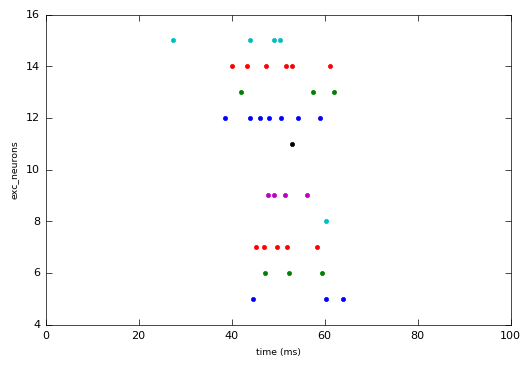

In [85]:
print np.shape(spikes_exc.segments[0].analogsignals)
print np.shape(inh_cells_data.segments[0].analogsignals)

n_panels = sum(a.shape[1] for a in spikes_exc.segments[0].analogsignals) + 1
print n_panels
plt.subplot(n_panels, 1, 1)
plot_spiketrains(spikes_exc.segments[0],'exc_neurons')
panel = 2
for array in spikes_exc.segments[0].analogsignals:
    for i in range(array.shape[1]):
        plt.subplot(n_panels, 1, panel)
        plot_signal(array, i, colour='bg'[panel % 2])
        panel += 1
plt.xlabel("time (ms)")
plt.setp(plt.gca().get_xticklabels(), visible=True)

plt.show()